In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## Define Functions

In [2]:
def create_class(df):
    # create Class attribute with np.select
    conditions = [df['NORMCOG']==1, (df['NORMCOG']==0) & (df['DEMENTED']==0), df['DEMENTED']==1]
    choices = [0,1,2] # 0 Normal Cog, 1 MCI, 2 Dementia
    df['Class'] = np.select(conditions, choices)

# Data contains binary attributes: NORMCOG and DEMENTED 
# will need to transform into 3 features where MCI is when NORMCOG and DEMENTED are both 0 (No)
def plot_class_bal(df):
    label_count = df['Class'].value_counts()
    # define parameters
    labels = ['Normal Cognition', 'MCI', 'Dementia']
    sizes = [label_count[0], label_count[1], label_count[2]]
    # assemble piechart
    plt.pie(sizes, labels=labels, startangle=400, colors=['darkseagreen', 'lightskyblue', 'dodgerblue'], autopct='%1.1f%%')
    plt.show()


def replace_with_na(df, column, list_to_replace):
    df[column] = df[column].where(~df[column].isin(list_to_replace), np.nan)

# create date column
def create_date_col(df):
    df['DATE'] = pd.to_datetime(
        df['VISITYR'].astype(str) + '-' +
        df['VISITMO'].astype(str).str.zfill(2) + '-' +
        df['VISITDAY'].astype(str).str.zfill(2)
        )
    return df

# create delta col: for choosing smallest interval between dates
def create_delta_col(df, datecolumn):
    # dynamically name column
    new_col_name = f'delta_{datecolumn}'

    # filter to not NA
    non_na = df[datecolumn].notna()

    # calc abs value of delta
    df[new_col_name] = abs(df.loc[non_na, 'DATE'] - df.loc[non_na, datecolumn]) # NACC date - scan date
    
    return df

## Read in NACC data

In [5]:
nacc = pd.read_csv("/Users/sarahbinder/Desktop/NACC Data/investigator_nacc66.csv", low_memory=False) 

# count unique IDs
# nacc contains longitudinal data, but for this project want to use each NACCID only once
nacc['NACCID'].nunique()

51836

In [6]:
nacc_slice = nacc.loc[:,['NACCID','VISITMO', 'VISITDAY', 'VISITYR', 'NORMCOG', 'DEMENTED']]

create_class(nacc_slice)
create_date_col(nacc_slice)

nacc_slice

,NACCID,VISITMO,VISITDAY,VISITYR,NORMCOG,DEMENTED,Class,DATE
0,NACC002909,12,28,2022,0,0,1,2022-12-28
1,NACC002909,1,23,2024,0,0,1,2024-01-23
2,NACC003487,11,15,2023,1,0,0,2023-11-15
3,NACC004352,10,5,2021,0,1,2,2021-10-05
4,NACC004687,11,14,2022,1,0,0,2022-11-14
...,...,...,...,...,...,...,...,...
192083,NACC998475,11,15,2007,0,0,1,2007-11-15
192084,NACC998475,11,6,2008,0,1,2,2008-11-06
192085,NACC999391,3,2,2006,0,0,1,2006-03-02
192086,NACC999391,5,17,2007,0,1,2,2007-05-17


## Read in SCAN

In [7]:
SCAN = pd.read_csv("/Users/sarahbinder/Desktop/NACC Data/investigator_scan_mri_nacc66/investigator_scan_mrisbm_nacc66.csv", low_memory=False)
print(SCAN.shape)
SCAN.head()

(1652, 200)


,NACCID,SCANDT,DESCRIPTION_T1,LONI_IMAGE_T1,DESCRIPTION_FLAIR,LONI_IMAGE_FLAIR,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,...,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH,NACCADC
0,NACC010462,2021-04-27,Accelerated Sagittal IR-FSPGR_(SCAN),10003856,Sagittal 3D FLAIR_(SCAN),10003855,1321.39,494.143,1.568,2.800,...,295,2.459,2.228,5919,6382,2265,2667,2.482,2.295,4032
1,NACC013705,2021-06-29,Accelerated Sagittal IR-FSPGR (SCAN),10005202,Sagittal 3D FLAIR (SCAN),10005201,1240.05,512.965,0.517,2.488,...,365,2.546,2.273,6465,6258,1905,1826,3.134,3.094,4032
2,NACC968063,2021-06-18,Accelerated Sagittal IR-FSPGR (SCAN),10004488,Sagittal 3D FLAIR (SCAN),10004487,1254.70,514.667,0.924,2.821,...,308,2.504,2.575,5615,6030,1838,2037,3.039,2.899,4032
3,NACC968063,2021-05-27,Accelerated Sagittal IR-FSPGR (SCAN),10004073,Sagittal 3D FLAIR (SCAN),10004074,1252.65,519.486,0.964,2.801,...,304,2.641,2.551,5739,6148,1872,2016,2.998,2.940,4032
4,NACC977601,2021-06-02,Accelerated Sagittal IR-FSPGR (SCAN),10004070,Sagittal 3D FLAIR (SCAN),10004071,1155.95,491.082,2.724,2.873,...,306,2.473,2.530,4837,4813,1714,1790,2.846,2.595,4032


In [8]:
# merge
merged_data = nacc_slice.merge(SCAN, how='left', on='NACCID')

In [9]:
# choose record per ID with smallest interval btwn NACC visit and SCAN visit

# ensure datetime type
merged_data['SCANDT'] = pd.to_datetime(merged_data['SCANDT'])

# create delta col
merged_data = create_delta_col(merged_data, 'SCANDT')

# remove NA rows
merged_notna = merged_data[merged_data['delta_SCANDT'].notna()]

# sort by delta, group by NACCID, to choose row per ID with the smallest delta
notna_sorted = merged_notna.sort_values(['NACCID', 'delta_SCANDT']).reset_index(drop=True)
selected_SCAN = notna_sorted.groupby('NACCID', as_index=False).first()


In [10]:
selected_SCAN.shape

(1462, 208)

In [11]:
# Filter out rows where there's more than 2.5 years btwn diagnosis and scan date 

# convert to days
selected_SCAN['delta_SCANDT_days'] = selected_SCAN['delta_SCANDT'].dt.days

#count
selected_SCAN[selected_SCAN['delta_SCANDT_days'] > 900] # 12 rows

# Filter out
selected_SCAN = selected_SCAN[selected_SCAN['delta_SCANDT_days'] <= 900]


In [12]:
selected_SCAN.shape

(1450, 209)

In [13]:
# remove description/ID cols
cols_list = ['NACCID', 'NACCADC', 'SCANDT', 'delta_SCANDT', 'delta_SCANDT_days', 'LONI_IMAGE_FLAIR', 'DESCRIPTION_FLAIR', 'LONI_IMAGE_T1', 'DESCRIPTION_T1', 'FREESURFER_VERSION']
nacc_added_cols = ['VISITMO','VISITDAY','VISITYR','NORMCOG','DEMENTED','DATE']

cols_drop = cols_list + nacc_added_cols

selected_SCAN.drop(cols_drop, axis=1, inplace=True)


In [14]:
scan = selected_SCAN # 1438 rows × 193 columns
scan

,Class,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,LH_CAUDALANTERIORCINGULATE_SAREA,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,0,1121.60,527.061,0.225588,2.93665,2.88859,5.82524,3135.0,2507.0,1083.0,...,396.0,303.0,2.494,2.514,6172.0,5995.0,1861.0,1837.0,3.070,3.080
1,2,1362.32,525.217,2.474000,2.96300,2.61400,5.57700,2999.0,2331.0,1385.0,...,424.0,282.0,2.017,1.969,6243.0,6254.0,2201.0,2309.0,2.697,2.593
2,0,1268.64,531.748,0.123000,3.23700,3.24400,6.48100,2787.0,1516.0,1120.0,...,555.0,374.0,2.156,2.355,5652.0,6048.0,2042.0,2077.0,2.765,2.941
3,0,1206.35,521.053,1.658000,3.22900,3.44000,6.66900,3090.0,2059.0,1281.0,...,430.0,328.0,2.444,2.428,5783.0,5601.0,1902.0,1921.0,2.823,2.692
4,2,1234.21,484.432,1.589000,2.25900,2.75400,5.01300,2344.0,1263.0,994.0,...,407.0,286.0,2.352,2.504,5013.0,5433.0,1500.0,1589.0,3.144,3.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,1,1490.38,641.687,16.030000,3.60600,2.99400,6.60000,3038.0,2786.0,1219.0,...,585.0,421.0,2.147,2.355,7449.0,7485.0,2396.0,2447.0,2.868,2.854
1458,0,1392.49,583.509,3.726000,2.93600,2.67900,5.61500,3247.0,2144.0,1308.0,...,435.0,294.0,2.240,2.513,6104.0,6327.0,1870.0,2201.0,3.123,2.799
1459,0,1356.90,570.520,0.766000,3.46800,3.73800,7.20600,3690.0,2375.0,1353.0,...,457.0,237.0,2.138,2.091,6435.0,6671.0,1821.0,1876.0,3.145,3.139
1460,1,1392.36,589.656,4.359460,3.02459,2.97565,6.00024,3827.0,2215.0,1519.0,...,443.0,303.0,2.151,2.438,6603.0,6299.0,2247.0,2093.0,2.713,2.815


In [15]:
# count na
scan.isna().sum()

Class               0
CEREBRUMTCV         0
GM                  0
WMH                10
LEFT_HIPPO          0
                   ..
RH_INSULA_GVOL      0
LH_INSULA_SAREA     0
RH_INSULA_SAREA     0
LH_INSULA_AVGTH     0
RH_INSULA_AVGTH     0
Length: 193, dtype: int64

In [16]:
# drop rows with na 10 rows
scan.dropna(inplace=True)

scan['Class'].value_counts()

Class
0    895
1    351
2    194
Name: count, dtype: int64

In [17]:
scan

,Class,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,LH_CAUDALANTERIORCINGULATE_SAREA,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,0,1121.60,527.061,0.225588,2.93665,2.88859,5.82524,3135.0,2507.0,1083.0,...,396.0,303.0,2.494,2.514,6172.0,5995.0,1861.0,1837.0,3.070,3.080
1,2,1362.32,525.217,2.474000,2.96300,2.61400,5.57700,2999.0,2331.0,1385.0,...,424.0,282.0,2.017,1.969,6243.0,6254.0,2201.0,2309.0,2.697,2.593
2,0,1268.64,531.748,0.123000,3.23700,3.24400,6.48100,2787.0,1516.0,1120.0,...,555.0,374.0,2.156,2.355,5652.0,6048.0,2042.0,2077.0,2.765,2.941
3,0,1206.35,521.053,1.658000,3.22900,3.44000,6.66900,3090.0,2059.0,1281.0,...,430.0,328.0,2.444,2.428,5783.0,5601.0,1902.0,1921.0,2.823,2.692
4,2,1234.21,484.432,1.589000,2.25900,2.75400,5.01300,2344.0,1263.0,994.0,...,407.0,286.0,2.352,2.504,5013.0,5433.0,1500.0,1589.0,3.144,3.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,1,1490.38,641.687,16.030000,3.60600,2.99400,6.60000,3038.0,2786.0,1219.0,...,585.0,421.0,2.147,2.355,7449.0,7485.0,2396.0,2447.0,2.868,2.854
1458,0,1392.49,583.509,3.726000,2.93600,2.67900,5.61500,3247.0,2144.0,1308.0,...,435.0,294.0,2.240,2.513,6104.0,6327.0,1870.0,2201.0,3.123,2.799
1459,0,1356.90,570.520,0.766000,3.46800,3.73800,7.20600,3690.0,2375.0,1353.0,...,457.0,237.0,2.138,2.091,6435.0,6671.0,1821.0,1876.0,3.145,3.139
1460,1,1392.36,589.656,4.359460,3.02459,2.97565,6.00024,3827.0,2215.0,1519.0,...,443.0,303.0,2.151,2.438,6603.0,6299.0,2247.0,2093.0,2.713,2.815


In [18]:
# export for next time
scan.to_csv('/Users/sarahbinder/Desktop/NACC Data/Imaging Analysis/scan.csv')

In [95]:
scan = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/Imaging Analysis/scan.csv',index_col=0)

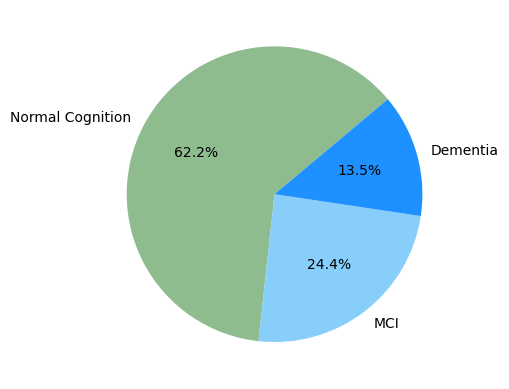

In [96]:
plot_class_bal(scan)

### Assess Feature Importance: after running RF/DT

In [ ]:
# after running RF or DT
# Extract feature importances
feature_importance = RF.feature_importances_

# Get the feature names directly from X_train_ros 
feature_names = X_train_ros.columns

# Create a DataFrame to store feature names and their corresponding importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(importance_df.head(10))

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='pink')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking from RF')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important at the top
plt.show()
____________

### Feature Correlation

In [97]:
# scan: high correlation btwn SAREA & GVOL

def cor_matrix(df, threshold=0.9):

    # set up cor matrix
    correlation_matrix = df.corr()
                   
    # Find pairs of features with correlation greater than the threshold
    high_corr_var = np.where(correlation_matrix > threshold)
    high_corr_var = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y] 
    print("Highly Correlated Feature Pairs (Threshold > 0.9):")
    print(high_corr_var)

cor_matrix(scan)

Highly Correlated Feature Pairs (Threshold > 0.9):
[('CEREBRUMTCV', 'GM'), ('LEFT_HIPPO', 'HIPPOCAMPUS'), ('RIGHT_HIPPO', 'HIPPOCAMPUS'), ('LH_CAUDALANTERIORCINGULATE_GVOL', 'LH_CAUDALANTERIORCINGULATE_SAREA'), ('LH_CAUDALMIDDLEFRONTAL_GVOL', 'LH_CAUDALMIDDLEFRONTAL_SAREA'), ('RH_CAUDALMIDDLEFRONTAL_GVOL', 'RH_CAUDALMIDDLEFRONTAL_SAREA'), ('LH_FUSIFORM_GVOL', 'LH_FUSIFORM_SAREA'), ('RH_FUSIFORM_GVOL', 'RH_FUSIFORM_SAREA'), ('LH_ISTHMUSCINGULATE_GVOL', 'LH_ISTHMUSCINGULATE_SAREA'), ('LH_MIDDLETEMPORAL_GVOL', 'LH_MIDDLETEMPORAL_SAREA'), ('RH_MIDDLETEMPORAL_GVOL', 'RH_MIDDLETEMPORAL_SAREA'), ('LH_PARSOPERCULARIS_GVOL', 'LH_PARSOPERCULARIS_SAREA'), ('RH_PARSOPERCULARIS_GVOL', 'RH_PARSOPERCULARIS_SAREA'), ('LH_PARSTRIANGULARIS_GVOL', 'LH_PARSTRIANGULARIS_SAREA'), ('RH_PARSTRIANGULARIS_GVOL', 'RH_PARSTRIANGULARIS_SAREA'), ('LH_POSTERIORCINGULATE_GVOL', 'LH_POSTERIORCINGULATE_SAREA'), ('LH_PRECUNEUS_GVOL', 'LH_PRECUNEUS_SAREA'), ('RH_PRECUNEUS_GVOL', 'RH_PRECUNEUS_SAREA'), ('LH_ROSTRALMIDDLEF

In [98]:
# remove cols that end with 'SAREA'
df = scan.loc[:, ~scan.columns.str.endswith('SAREA')]

In [99]:
df

,Class,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,LH_CAUDALANTERIORCINGULATE_AVGTH,...,LH_SUPRAMARGINAL_AVGTH,RH_SUPRAMARGINAL_AVGTH,LH_TRANSVERSETEMPORAL_GVOL,RH_TRANSVERSETEMPORAL_GVOL,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,0,1121.60,527.061,0.225588,2.93665,2.88859,5.82524,3135.0,2507.0,2.610,...,2.675,2.568,1129.0,790.0,2.494,2.514,6172.0,5995.0,3.070,3.080
1,2,1362.32,525.217,2.474000,2.96300,2.61400,5.57700,2999.0,2331.0,2.090,...,2.265,2.303,921.0,587.0,2.017,1.969,6243.0,6254.0,2.697,2.593
2,0,1268.64,531.748,0.123000,3.23700,3.24400,6.48100,2787.0,1516.0,2.236,...,2.410,2.326,1338.0,1043.0,2.156,2.355,5652.0,6048.0,2.765,2.941
3,0,1206.35,521.053,1.658000,3.22900,3.44000,6.66900,3090.0,2059.0,2.255,...,2.520,2.481,1084.0,901.0,2.444,2.428,5783.0,5601.0,2.823,2.692
4,2,1234.21,484.432,1.589000,2.25900,2.75400,5.01300,2344.0,1263.0,2.291,...,2.487,2.340,950.0,915.0,2.352,2.504,5013.0,5433.0,3.144,3.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,1,1490.38,641.687,16.030000,3.60600,2.99400,6.60000,3038.0,2786.0,2.366,...,2.377,2.356,1414.0,1225.0,2.147,2.355,7449.0,7485.0,2.868,2.854
1458,0,1392.49,583.509,3.726000,2.93600,2.67900,5.61500,3247.0,2144.0,2.334,...,2.524,2.486,1026.0,792.0,2.240,2.513,6104.0,6327.0,3.123,2.799
1459,0,1356.90,570.520,0.766000,3.46800,3.73800,7.20600,3690.0,2375.0,2.444,...,2.084,2.395,1123.0,591.0,2.138,2.091,6435.0,6671.0,3.145,3.139
1460,1,1392.36,589.656,4.359460,3.02459,2.97565,6.00024,3827.0,2215.0,2.417,...,2.340,2.295,1009.0,860.0,2.151,2.438,6603.0,6299.0,2.713,2.815


In [100]:
cor_matrix(df)

Highly Correlated Feature Pairs (Threshold > 0.9):
[('CEREBRUMTCV', 'GM'), ('LEFT_HIPPO', 'HIPPOCAMPUS'), ('RIGHT_HIPPO', 'HIPPOCAMPUS')]


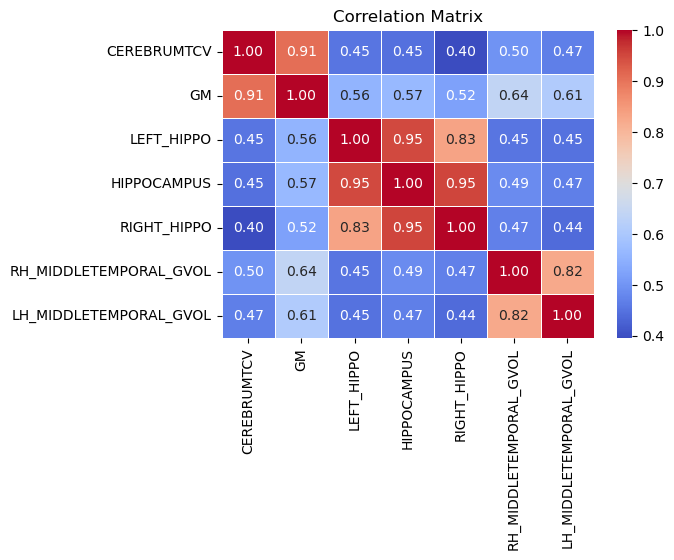

In [101]:
#plot cor matrix for those remaining with > threshold 
corr_matrix = df[['CEREBRUMTCV','GM','LEFT_HIPPO','HIPPOCAMPUS','RIGHT_HIPPO','RH_MIDDLETEMPORAL_GVOL','LH_MIDDLETEMPORAL_GVOL']].corr()

# plot
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [102]:
# drop one of pair of highly corr
df = df.drop(columns=['CEREBRUMTCV', 'HIPPOCAMPUS'])


In [94]:
# # cor matrix again of first 10 features
# dft2 = df_t.iloc[:,:10].copy()
# corr_matrix_2 = dft2.corr()

# # plot
# plt.figure(figsize=(6, 4))
# sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Correlation Matrix")
# plt.show()

### RH LH Avg

In [103]:
# identify RH and LH cols
left = df.loc[:,df.columns.str.startswith('LH')] #62 cols
right = df.loc[:,df.columns.str.startswith('RH')] # 62 cols

# create column showing difference between R and L hemispheric regions
avg_df = pd.DataFrame()

# Compute the differences
for l_col, r_col in zip(left.columns, right.columns):
    # remove prefix 
    feature_name = l_col[3:]
    # compute diff
    avg_df[f'{feature_name}_avg'] = (df[l_col] + df[r_col])/2

# add diff cols to df
df_a = pd.concat([df, avg_df], axis=1)

# drop RH and LH cols
cols_drop = list(left.columns) + list(right.columns)
df_a.drop(columns=cols_drop,inplace=True)

# RHIPPO LHIPPO dif naming convention
df_a['HIPPO_avg'] = (df_a['LEFT_HIPPO'] + df_a['RIGHT_HIPPO'])/2
df_a.drop(columns=['LEFT_HIPPO','RIGHT_HIPPO'], inplace=True)
df_a


,Class,GM,WMH,CAUDALANTERIORCINGULATE_GVOL_avg,CAUDALANTERIORCINGULATE_AVGTH_avg,CAUDALMIDDLEFRONTAL_GVOL_avg,CAUDALMIDDLEFRONTAL_AVGTH_avg,CUNEUS_GVOL_avg,CUNEUS_AVGTH_avg,ENTORHINAL_GVOL_avg,...,SUPERIORPARIETAL_AVGTH_avg,SUPERIORTEMPORAL_GVOL_avg,SUPERIORTEMPORAL_AVGTH_avg,SUPRAMARGINAL_GVOL_avg,SUPRAMARGINAL_AVGTH_avg,TRANSVERSETEMPORAL_GVOL_avg,TRANSVERSETEMPORAL_AVGTH_avg,INSULA_GVOL_avg,INSULA_AVGTH_avg,HIPPO_avg
0,0,527.061,0.225588,2821.0,2.5640,7023.5,2.4625,3826.5,1.8770,1433.0,...,2.0700,15248.0,2.7975,7925.0,2.6215,959.5,2.5040,6083.5,3.0750,2.91262
1,2,525.217,2.474000,2665.0,1.9500,5721.5,2.3115,3414.5,1.9320,821.5,...,2.0175,12454.5,2.2280,9255.0,2.2840,754.0,1.9930,6248.5,2.6450,2.78850
2,0,531.748,0.123000,2151.5,2.2080,6461.5,2.4310,3697.0,1.7910,1607.5,...,2.0835,15688.0,2.6620,9295.5,2.3680,1190.5,2.2555,5850.0,2.8530,3.24050
3,0,521.053,1.658000,2574.5,2.1310,5995.0,2.5110,3998.0,2.1885,1556.0,...,2.3115,14955.0,2.7150,9031.5,2.5005,992.5,2.4360,5692.0,2.7575,3.33450
4,2,484.432,1.589000,1803.5,2.2855,6064.5,2.3410,4322.5,2.0285,619.0,...,2.2170,10491.5,2.4260,8240.5,2.4135,932.5,2.4280,5223.0,3.1035,2.50650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,1,641.687,16.030000,2912.0,2.3005,6257.5,2.7030,4169.5,2.0890,4018.0,...,2.3605,15571.5,2.4920,10877.0,2.3665,1319.5,2.2510,7467.0,2.8610,3.30000
1458,0,583.509,3.726000,2695.5,2.3480,6490.5,2.4760,3909.0,1.9185,2004.0,...,2.1540,15307.5,2.6050,10222.0,2.5050,909.0,2.3765,6215.5,2.9610,2.80750
1459,0,570.520,0.766000,3032.5,2.4610,7228.5,2.2610,3245.0,1.8110,1790.0,...,2.0885,13940.5,2.5520,8521.0,2.2395,857.0,2.1145,6553.0,3.1420,3.60300
1460,1,589.656,4.359460,3021.0,2.3535,6437.0,2.2965,4548.5,1.9025,1414.0,...,2.1795,16314.0,2.5280,10297.5,2.3175,934.5,2.2945,6451.0,2.7640,3.00012


In [105]:
# # cor matrix again of first 10 features
# dfa = df_a.iloc[:,:10].copy()
# corr_matrix_3 = dfa.corr()

# # plot
# plt.figure(figsize=(6, 4))
# sns.heatmap(corr_matrix_3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Correlation Matrix")
# plt.show()

### Split, Normalize (min-max), SMOTE

In [106]:
# 1) split data into train and test, inputs and output

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# define X and y
X = df_a.drop('Class', axis=1) # drop class
y = df_a['Class']  # select class (target) variable only

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=303, stratify=y)

# normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)       # Transform only (not fit) to avoid data leakage (possibility of using min/max from the test set)

# initialize SMOTE
smote = SMOTE(random_state=303) 

# fit SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



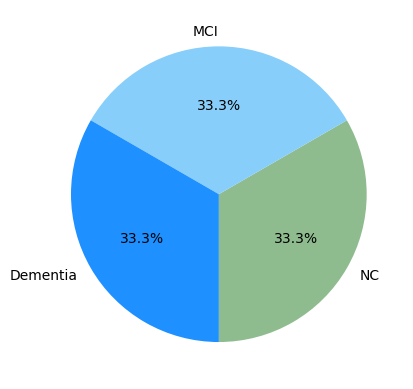

In [107]:
# count 0s and 1s in Label column
label_count = y_train_smote.value_counts()

# define parameters
labels = ['NC', 'MCI', 'Dementia']
sizes = [label_count[0], label_count[1], label_count[2]]

# assemble piechart
plt.pie(sizes, labels=labels, startangle=270,colors=['darkseagreen', 'lightskyblue', 'dodgerblue'], autopct='%1.1f%%')
plt.show()

### Evaluate function

In [71]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

def evaluate(model, X_test=X_test, y_test=y_test):
    
    # define variables
    y_pred = model.predict(X_test) # run model on test data
    y_pred_prob = model.predict_proba(X_test) # for auc, shows probabilities of positive class
    
    # calculate metrics 
    metrics_dict = {
    'A': round(accuracy_score(y_test, y_pred),3), 
    'auc': round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted'),3), # ovr = one vs rest for multiclass
    'F': round(f1_score(y_test, y_pred, average='weighted'),3),
    'P': round(precision_score(y_test, y_pred, average='weighted'),3),
    'R': round(recall_score(y_test, y_pred, average='weighted'),3) # average='weighted' for multi-class
    }
    return metrics_dict
    

### kNN Classifier w 10-fold xval

In [72]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

def k_fold_kNN(X_train, y_train, n_neighbors=2, n_splits=10):
    
    # Set up K-Fold 
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=303)
    
    # Initialize fold counter
    fold = 1
    
    # Initialize dictionary to store results
    folds_dict = {}
    
    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Split data per fold
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val = X_train[val_idx]
        y_val = y_train[val_idx]
    
        model = KNeighborsClassifier(n_neighbors=n_neighbors)# init
        model.fit(X_train_fold, y_train_fold) # fit
    
        # Evaluate model on validation data
        metrics_dict = evaluate(model, X_test=X_val, y_test=y_val)  
        folds_dict[f'Fold {fold}'] = metrics_dict
        fold += 1
    
    # Calculate average metrics
    average_metrics = {
        metric: round(np.mean([fold_metrics[metric] for fold_metrics in folds_dict.values()]), 3)
        for metric in folds_dict['Fold 1'] 
    }
    
    return average_metrics


### Iterate over dif kNN parameters

In [108]:
# init dictionary
results_dict = {}

In [110]:
for n in [2,3,5,10,20]:
    model_name = f'kNN SCAN 10-Fold: n={n}'
    results_dict[model_name] = k_fold_kNN(X_train_smote, y_train_smote, n_neighbors=n)

results_dict

{'kNN SCAN 10-Fold: n=2': {'A': 0.819,
  'auc': 0.877,
  'F': 0.808,
  'P': 0.838,
  'R': 0.819},
 'kNN SCAN 10-Fold: n=3': {'A': 0.76,
  'auc': 0.893,
  'F': 0.732,
  'P': 0.799,
  'R': 0.76},
 'kNN SCAN 10-Fold: n=5': {'A': 0.738,
  'auc': 0.898,
  'F': 0.71,
  'P': 0.776,
  'R': 0.738},
 'kNN SCAN 10-Fold: n=10': {'A': 0.691,
  'auc': 0.873,
  'F': 0.665,
  'P': 0.728,
  'R': 0.691},
 'kNN SCAN 10-Fold: n=20': {'A': 0.627,
  'auc': 0.833,
  'F': 0.603,
  'P': 0.662,
  'R': 0.627}}

# RF

In [117]:
from sklearn.ensemble import RandomForestClassifier 

def k_fold_RF(X_train, y_train, n_estimators=5, n_splits=10):
    
    # Set up K-Fold 
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=303)
    
    # Initialize fold counter
    fold = 1
    
    # Initialize dictionary to store results
    folds_dict = {}
    
    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Split data per fold
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val = X_train[val_idx]
        y_val = y_train[val_idx]

        # init and fit
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=303)
        model.fit(X_train_fold, y_train_fold) # fit
    
        # Evaluate model on validation data
        metrics_dict = evaluate(model, X_test=X_val, y_test=y_val)  
        folds_dict[f'Fold {fold}'] = metrics_dict
        fold += 1
    
    # Calculate average metrics
    average_metrics = {
        metric: round(np.mean([fold_metrics[metric] for fold_metrics in folds_dict.values()]), 3)
        for metric in folds_dict['Fold 1'] 
    }
    
    return average_metrics

In [118]:
for t in [5,10,20]:
    model_name = f'RF SCAN 10-Fold: t={t}'
    results_dict[model_name] = k_fold_RF(X_train_smote, y_train_smote, n_estimators=t)

results_dict

{'kNN SCAN 10-Fold: n=2': {'A': 0.819,
  'auc': 0.877,
  'F': 0.808,
  'P': 0.838,
  'R': 0.819},
 'kNN SCAN 10-Fold: n=3': {'A': 0.76,
  'auc': 0.893,
  'F': 0.732,
  'P': 0.799,
  'R': 0.76},
 'kNN SCAN 10-Fold: n=5': {'A': 0.738,
  'auc': 0.898,
  'F': 0.71,
  'P': 0.776,
  'R': 0.738},
 'kNN SCAN 10-Fold: n=10': {'A': 0.691,
  'auc': 0.873,
  'F': 0.665,
  'P': 0.728,
  'R': 0.691},
 'kNN SCAN 10-Fold: n=20': {'A': 0.627,
  'auc': 0.833,
  'F': 0.603,
  'P': 0.662,
  'R': 0.627},
 'RF SCAN 10-Fold: t=5': {'A': 0.752,
  'auc': 0.893,
  'F': 0.753,
  'P': 0.761,
  'R': 0.752},
 'RF SCAN 10-Fold: t=10': {'A': 0.814,
  'auc': 0.93,
  'F': 0.814,
  'P': 0.816,
  'R': 0.814},
 'RF SCAN 10-Fold: t=20': {'A': 0.836,
  'auc': 0.946,
  'F': 0.835,
  'P': 0.837,
  'R': 0.836}}

In [119]:
# convert dictionary to Dataframe
final_df = pd.DataFrame.from_dict(results_dict, orient='index') # orient=index ensures keys (model names) are rows # model_name is index

# rename columns
final_df.columns = ['Accuracy', 'AUC', 'F-measure', 'Precision', 'Recall']

# view
final_df

,Accuracy,AUC,F-measure,Precision,Recall
kNN SCAN 10-Fold: n=2,0.819,0.877,0.808,0.838,0.819
kNN SCAN 10-Fold: n=3,0.760,0.893,0.732,0.799,0.760
kNN SCAN 10-Fold: n=5,0.738,0.898,0.710,0.776,0.738
kNN SCAN 10-Fold: n=10,0.691,0.873,0.665,0.728,0.691
kNN SCAN 10-Fold: n=20,0.627,0.833,0.603,0.662,0.627
RF SCAN 10-Fold: t=5,0.752,0.893,0.753,0.761,0.752
RF SCAN 10-Fold: t=10,0.814,0.930,0.814,0.816,0.814
RF SCAN 10-Fold: t=20,0.836,0.946,0.835,0.837,0.836


In [120]:
from tabulate import tabulate
print(tabulate(final_df, headers='keys', tablefmt='latex'))


\begin{tabular}{lrrrrr}
\hline
                        &   Accuracy &   AUC &   F-measure &   Precision &   Recall \\
\hline
 kNN SCAN 10-Fold: n=2  &      0.819 & 0.877 &       0.808 &       0.838 &    0.819 \\
 kNN SCAN 10-Fold: n=3  &      0.76  & 0.893 &       0.732 &       0.799 &    0.76  \\
 kNN SCAN 10-Fold: n=5  &      0.738 & 0.898 &       0.71  &       0.776 &    0.738 \\
 kNN SCAN 10-Fold: n=10 &      0.691 & 0.873 &       0.665 &       0.728 &    0.691 \\
 kNN SCAN 10-Fold: n=20 &      0.627 & 0.833 &       0.603 &       0.662 &    0.627 \\
 RF SCAN 10-Fold: t=5   &      0.752 & 0.893 &       0.753 &       0.761 &    0.752 \\
 RF SCAN 10-Fold: t=10  &      0.814 & 0.93  &       0.814 &       0.816 &    0.814 \\
 RF SCAN 10-Fold: t=20  &      0.836 & 0.946 &       0.835 &       0.837 &    0.836 \\
\hline
\end{tabular}
